In [3]:
import os
import json
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm

In [4]:
sns.set_style("ticks")
sns.set_context("paper")

In [5]:
MODES = ["textual", "visual"]

## Loading Results

In [6]:
save_dir = "outputs/gcbc_eval/GCBC-CALVIN-s1"
# save_dir = "../outputs/gcbc_eval/last"

In [10]:
result_keys = ["results", "evaluated_idxs"]
results_dict = {
    "textual": {k: None for k in result_keys},
    "visual": {k: None for k in result_keys},
}
results_dict["textual"]["save_dir"] = os.path.join(save_dir, "textual")
results_dict["visual"]["save_dir"] = os.path.join(save_dir, "visual")

In [11]:
for mode in MODES:
    for key in result_keys:
        if key != 'videos_metadata':
            file_path = os.path.join(results_dict[mode]['save_dir'], f'{key}.npz')
            results_dict[mode][key] = dict(**np.load(file_path))
        else:
            file_path = os.path.join(results_dict[mode]['save_dir'], f'{key}.json')
            with open(file_path, 'r') as f:
                results_dict[mode][key] = json.load(f)

In [12]:
tasks = list(results_dict['textual']['results'].keys())
n_tasks = len(tasks)

## Success Rate

In [13]:
for mode in MODES:
    results = results_dict[mode]['results']
    success_rates = {k: v.sum() / v.size for k, v in results.items()}
    total_sr = sum([v.sum() for v in results.values()]) / sum(
        [len(v) for v in results.values()]
    )
    results_dict[mode]['success_rates'] = success_rates
    results_dict[mode]['total_sr'] = total_sr

### Main

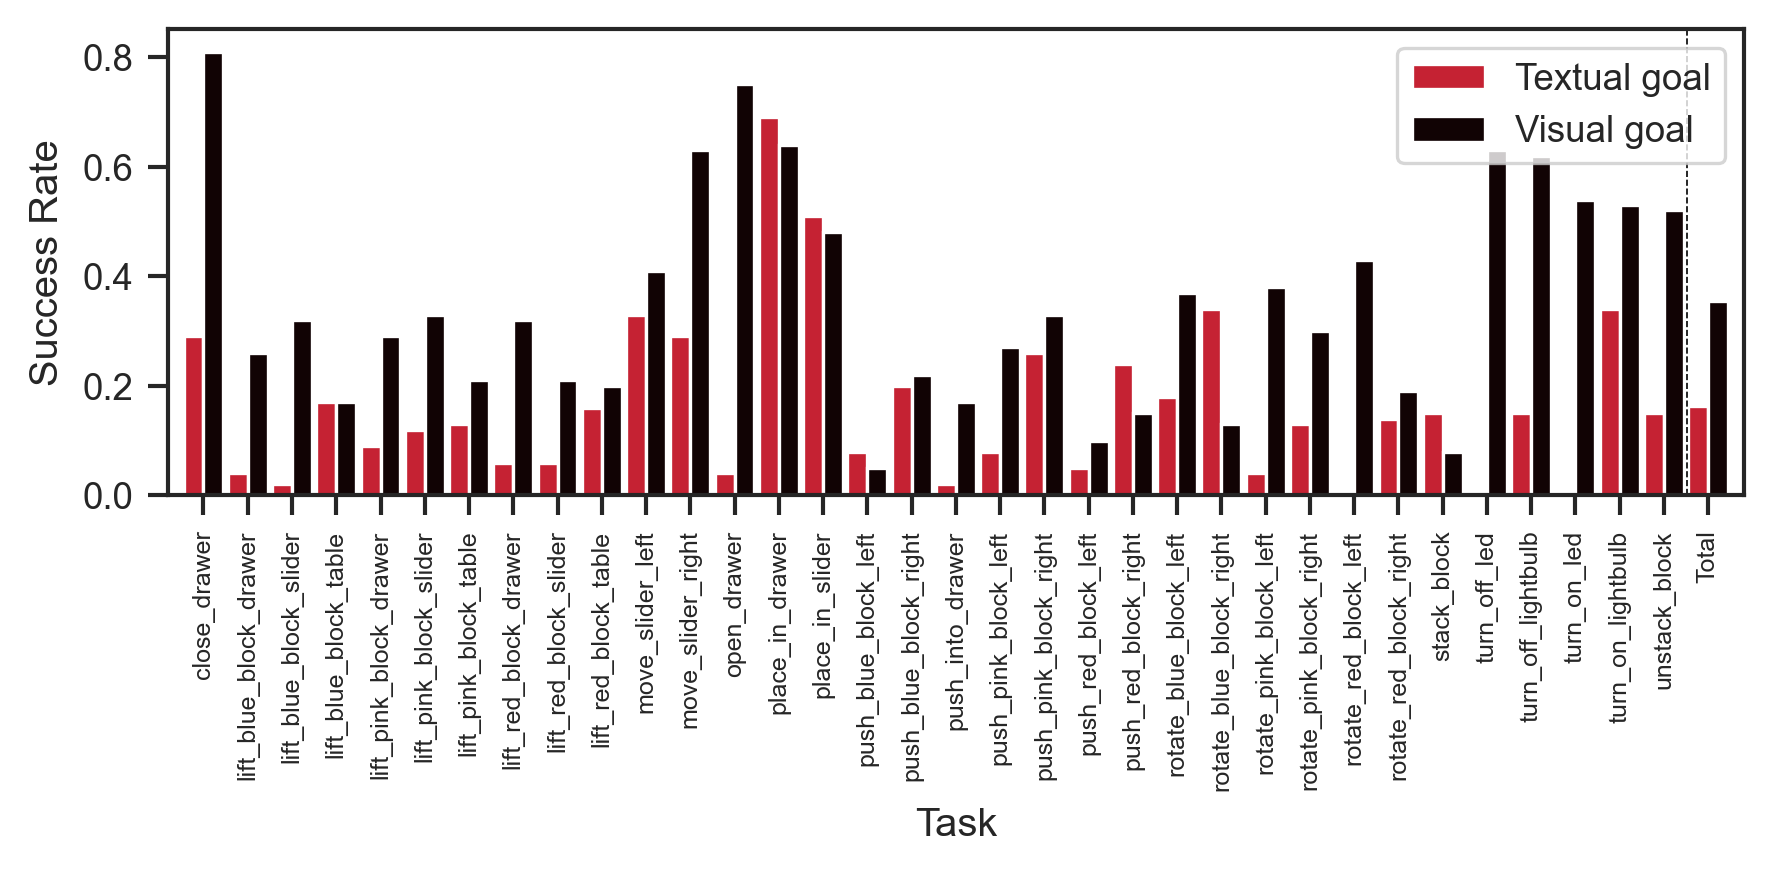

In [14]:
f, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

# Position of bars on x-axis (+1 cuz we also plot the total SR
ind = np.arange(n_tasks + 1)
# Width of a bar
width = 0.45

textual_sr = [results_dict["textual"]["success_rates"][task] for task in tasks]
textual_total_sr = results_dict["textual"]["total_sr"]

visual_sr = [results_dict["visual"]["success_rates"][task] for task in tasks]
visual_total_sr = results_dict["visual"]["total_sr"]
    
ax.bar(
    x=ind[:-1], height=textual_sr, width=width, color="#C52233", label="Textual goal"
)
ax.bar(
    x=ind[:-1] + width,
    height=visual_sr,
    width=width,
    color="#110304",
    label="Visual goal",
)

ax.bar(x=ind[-1], height=textual_total_sr, width=width, color='#C52233')
ax.bar(x=ind[-1] + width, height=visual_total_sr, width=width, color='#110304')

ax.axvline(x=len(tasks) - 0.25, color="black", linestyle="dashed", linewidth=0.4)

ax.set_xticks(ind + width / 2, tasks + ['Total'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)

ax.set_ylabel("Success Rate")
ax.set_xlabel("Task")

ax.margins(x=0.01)
ax.legend(loc='upper right')

f.set_tight_layout(True)
plt.show()

In [15]:
sr_df = pd.DataFrame.from_records(
    [results_dict[mode]["success_rates"] for mode in MODES],
    index=["Textual Success Rate", "Visual Success Rate"],
)
sr_stats = sr_df.T.describe()
sr_df["Total"] = [textual_total_sr, visual_total_sr]

In [16]:
sr_df

,close_drawer,lift_blue_block_drawer,lift_blue_block_slider,lift_blue_block_table,lift_pink_block_drawer,lift_pink_block_slider,lift_pink_block_table,lift_red_block_drawer,lift_red_block_slider,lift_red_block_table,...,rotate_pink_block_right,rotate_red_block_left,rotate_red_block_right,stack_block,turn_off_led,turn_off_lightbulb,turn_on_led,turn_on_lightbulb,unstack_block,Total
Textual Success Rate,0.29,0.04,0.02,0.17,0.09,0.12,0.13,0.06,0.06,0.16,...,0.13,0.00,0.14,0.15,0.00,0.15,0.00,0.34,0.15,0.163235
Visual Success Rate,0.81,0.26,0.32,0.17,0.29,0.33,0.21,0.32,0.21,0.20,...,0.30,0.43,0.19,0.08,0.63,0.62,0.54,0.53,0.52,0.354118


In [17]:
sr_stats

,Textual Success Rate,Visual Success Rate
count,34.000000,34.000000
mean,0.163235,0.354118
std,0.151971,0.199729
min,0.000000,0.050000
25%,0.052500,0.202500
50%,0.135000,0.320000
75%,0.230000,0.510000
max,0.690000,0.810000
